In [2]:
import numpy as np
import rebound
import reboundx
import matplotlib.pyplot as plt
from tqdm import tqdm
#import kgpreamble as kg
#kg.set_mplstyle_paper()

In [2]:
def plot_snapshot(sim, a_b):
    fig, ax = plt.subplots(figsize = (18,12), nrows = 3, ncols = 1)

    for i in range(sim.N-2):
        ax[0].scatter(sim.particles[i+2].x, sim.particles[i+2].y, color = 'gray', alpha = 0.4, lw = 0.5)
        ax[1].scatter(sim.particles[i+2].x, sim.particles[i+2].z, color = 'gray', alpha = 0.4, lw = 0.5)
        ax[2].scatter(sim.particles[i+2].y, sim.particles[i+2].z, color = 'gray', alpha = 0.4, lw = 0.5)

    for j in [0, 1]:
        ax[0].scatter(sim.particles[j].x, sim.particles[j].y, color = 'orange', lw =5)
        ax[1].scatter(sim.particles[j].x, sim.particles[j].z, color = 'orange', lw =5)
        ax[2].scatter(sim.particles[j].y, sim.particles[j].z, color = 'orange', lw =5)

    for a in ax:
        a.axis('equal')
        a.set(xlim = (-0.75*a_b, 0.75*a_b))
        

    ax[0].set(xlabel = r'$x$[AU]', ylabel = r'$y$[AU]')
    ax[1].set(xlabel = r'$x$[AU]', ylabel = r'$z$[AU]')
    ax[2].set(xlabel = r'$y$[AU]', ylabel = r'$z$[AU]')

In [3]:
sim = rebound.Simulation()
sim.integrator="whfast"
sim.add(m = 1)


# set up binary
a_b = 500
binary_inc = np.radians(5)
sim.add(m = 1, a = a_b, inc = binary_inc)


# set up debris disk
N_particles = 250
r_min = 20; r_max = 100; disk_width = np.abs(r_min-r_max)
semi_major_axes_lin = np.linspace(r_min, r_max, N_particles)
p_sd = -1
Surface_density = np.array([(r**p_sd) for r in semi_major_axes_lin])
Surface_density_norm = Surface_density/np.sum(Surface_density)
Delta_rs = np.array([1/Surface_density_norm[i] for i in range(N_particles)])
Delta_rs_norm = disk_width * Delta_rs/np.sum(Delta_rs)
semi_major_axes = np.array([r_min + np.sum(Delta_rs_norm[:i]) for i in range(N_particles)])

#plt.scatter(semi_major_axes, np.linspace(0,1,500), lw =0.1, alpha =0.5)

anamolies = np.array([2*np.pi*np.random.rand() for N in range(N_particles)])


i = 0
for N in range(N_particles):
    sim.add(m = 0, a = semi_major_axes[i], omega = anamolies[i], primary = sim.particles[0])
    
    i += 1



# rotate towards binary orbital normal
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())
sim.rotate(rot)
print(sim.angular_momentum())

sim.move_to_com()

hvec_list = np.zeros((N_particles, 3))
for N in range(N_particles):
    hvec = sim.particles[N+2].calculate_orbit(primary=sim.particles[0]).hvec
    hvec_list[N] = np.array([hvec.x, hvec.y, hvec.z])/np.linalg.norm([hvec.x, hvec.y, hvec.z])
initial_disk_hvec = np.average(hvec_list, axis = 0)
print(initial_disk_hvec)

<rebound.simulation.Vec3d object at 0x12fd13970, [0.0, 8.673617379884035e-16, 31.622776601683793]>
[2.81517391e-19 8.71557427e-02 9.96194698e-01]


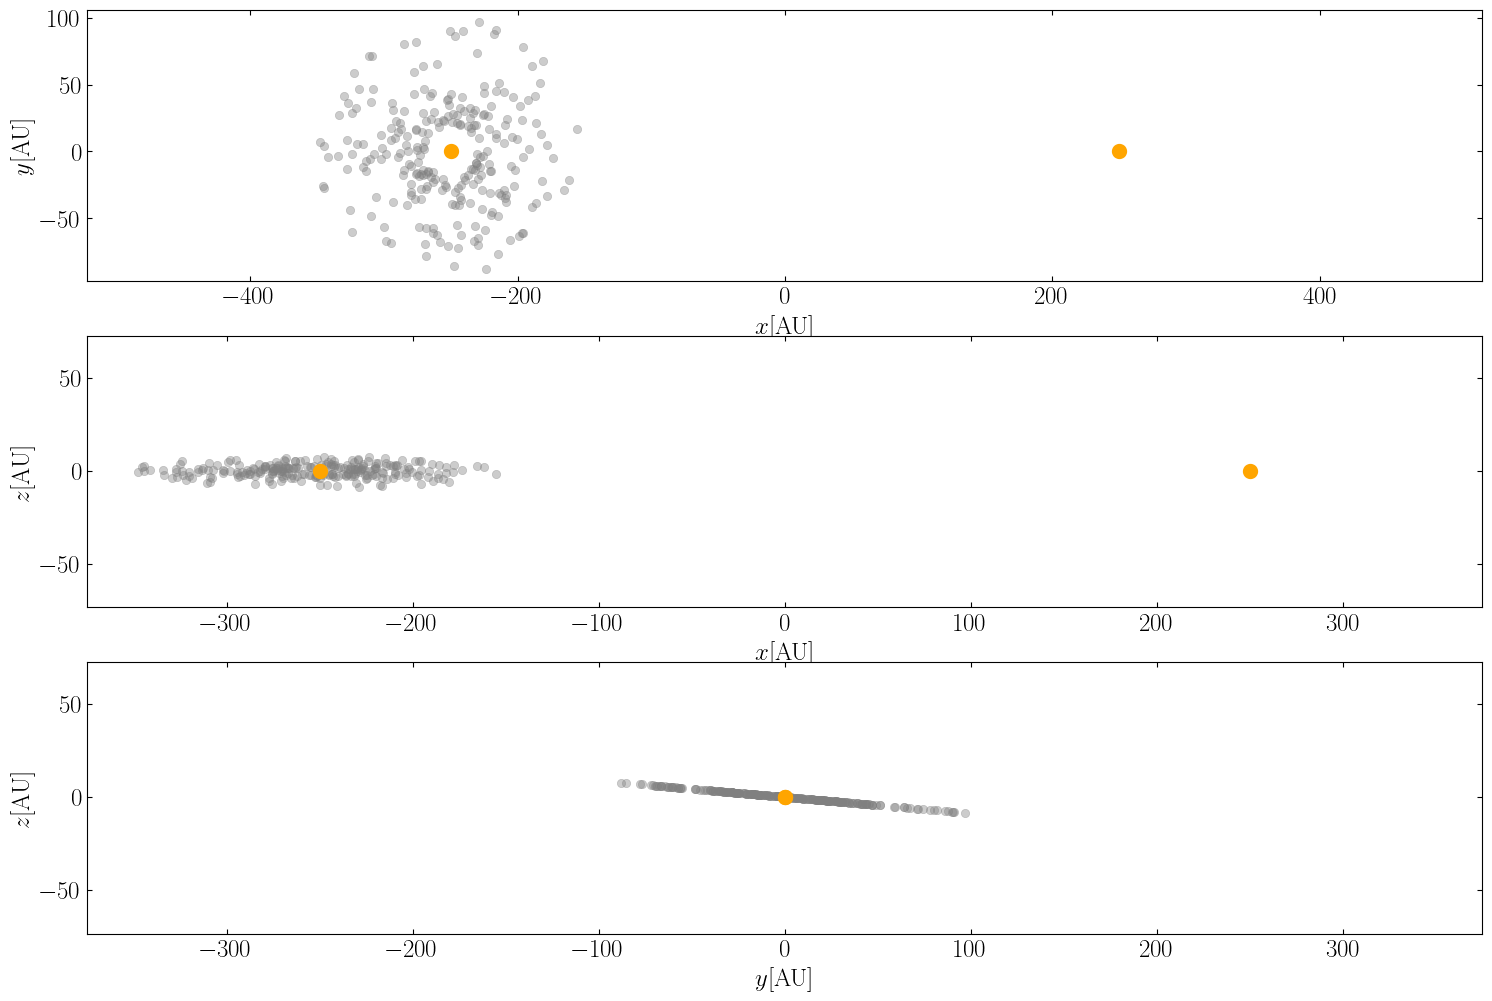

In [4]:
plot_snapshot(sim, a_b)

In [5]:
# Define integration time
tmax =  1e6 * 2* np.pi
tstep = 10 * 2 * np.pi
times = np.arange(0, tmax, tstep)
Nout = len(times) # number of time steps

sim.dt = sim.particles[2].calculate_orbit(primary=sim.particles[0]).P / 10.12345

theta_db = np.zeros((Nout, sim.N-1))
theta_pb = np.zeros(Nout)
theta_dp = np.zeros((Nout, sim.N-1))


p = np.zeros((Nout, sim.N-1, 4))
for i, t in tqdm(enumerate(times)):
    sim.integrate(t)
    hvec = sim.particles[1].calculate_orbit(primary=sim.particles[0]).hvec
    hvec = np.array([hvec.x, hvec.y, hvec.z])/np.linalg.norm([hvec.x, hvec.y, hvec.z])
    theta_pb[i] = np.arccos(np.dot([0,0,1], hvec))

    for n in range(sim.N-2):
        orbit = sim.particles[n+1].calculate_orbit(primary=sim.particles[0])
        a = orbit.a
        e = orbit.e
        pomega = orbit.pomega
        inc = orbit.inc
        p[i][n+1] = a, e, pomega, inc

        testp_hvec = orbit.hvec
        testp_hvec = np.array([testp_hvec.x, testp_hvec.y, testp_hvec.z])/np.linalg.norm([testp_hvec.x, testp_hvec.y, testp_hvec.z])
        theta_db[i, n+1] = np.arccos(np.dot(hvec, testp_hvec))
        
        
        theta_dp[i, n+1] = np.arccos(np.dot(initial_disk_hvec, testp_hvec))
        




    

0it [00:00, ?it/s]/var/folders/p3/bjnwvzss7tn5vq38kn9h133r0000gn/T/ipykernel_16257/1472035665.py:34: RuntimeWarning: invalid value encountered in arccos
  theta_dp[i, n+1] = np.arccos(np.dot(initial_disk_hvec, testp_hvec))
100000it [04:09, 400.52it/s]


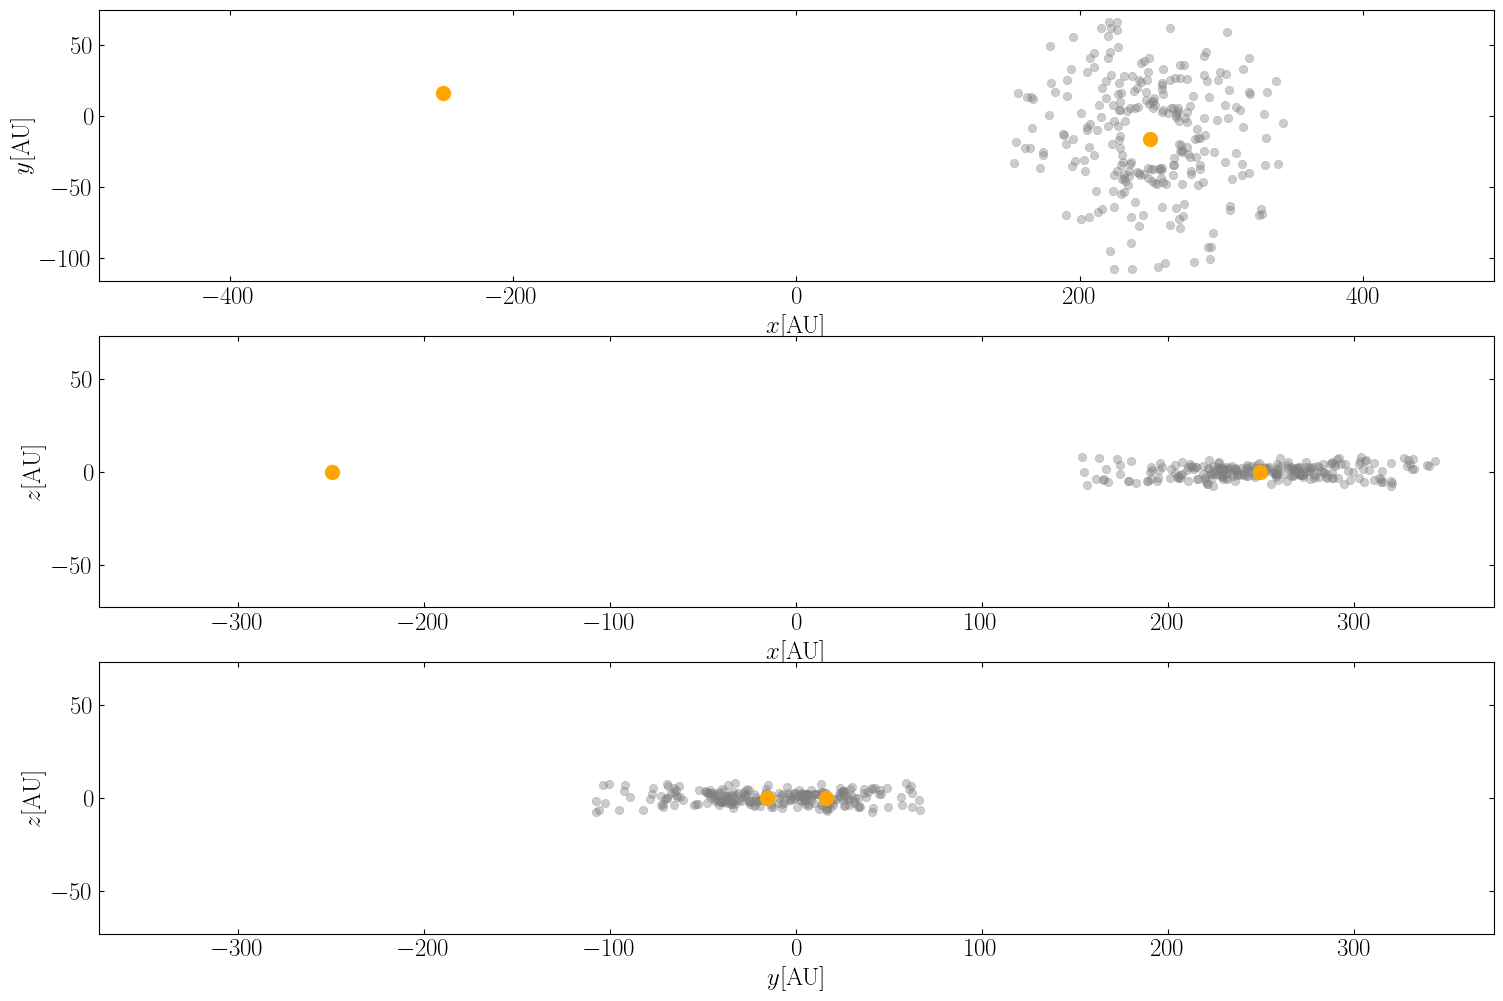

In [6]:
plot_snapshot(sim, a_b)

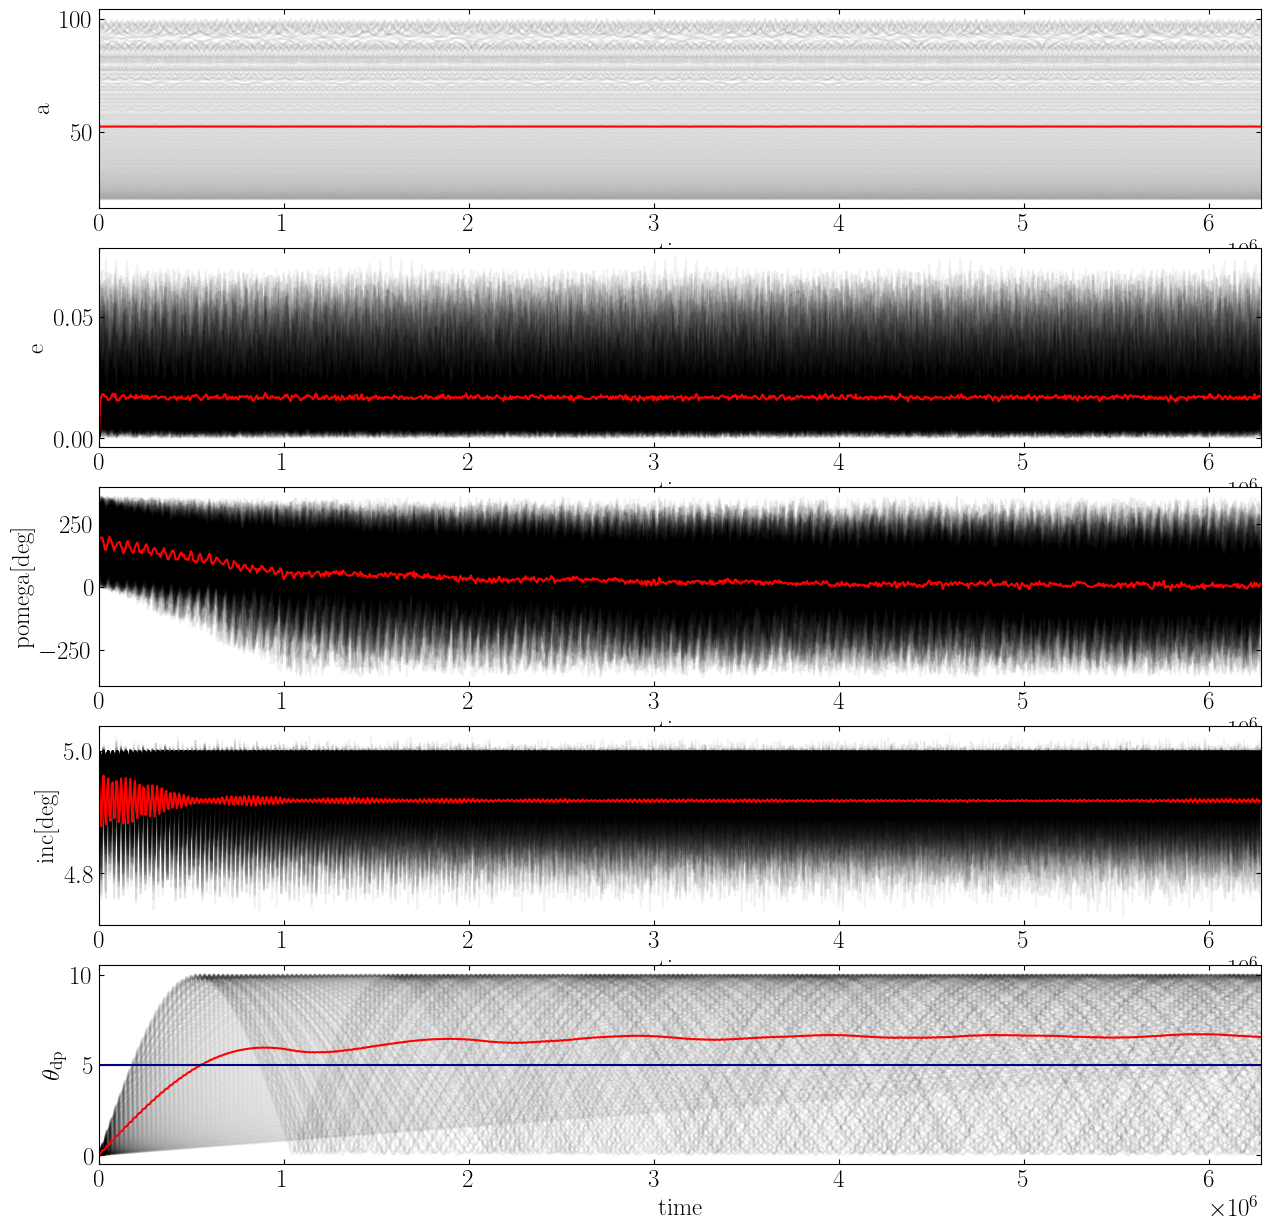

In [8]:
fig, ax = plt.subplots(figsize = (15, 15), nrows = 5)

freq=100
for n in range(sim.N-3):
    m = n+2
    ax[0].plot(times[::freq], p[:,m,0][::freq], alpha = 0.05, color = 'black')
    ax[1].plot(times[::freq], p[:,m,1][::freq], alpha = 0.05, color = 'black')
    ax[2].plot(times[::freq], np.degrees(p[:,m,2][::freq]), alpha = 0.05, color = 'black')
    ax[3].plot(times[::freq], np.degrees(p[:,m,3][::freq]), alpha = 0.05, color = 'black')
    ax[4].plot(times[::freq], np.degrees(theta_dp[:,m][::freq]), alpha = 0.05, color = 'black')

ax[0].plot(times[::freq], np.average(p[:,:,0][::freq], axis = 1), color = 'red')
ax[1].plot(times[::freq], np.average(p[:,:,1][::freq], axis = 1), color = 'red')
ax[2].plot(times[::freq], np.degrees(np.average(p[:,:,2][::freq], axis = 1)), color = 'red')
ax[3].plot(times[::freq], np.degrees(np.average(p[:,:,3][::freq], axis = 1)), color = 'red')
ax[4].plot(times[::freq], np.degrees(np.average(theta_dp[:][::freq], axis = 1)), color = 'red')

ax[4].axhline(np.degrees(binary_inc), color = 'navy')



ax[0].set(ylabel = 'a')
ax[1].set(ylabel = 'e')
ax[2].set(ylabel = 'pomega[deg]')
ax[3].set(ylabel = 'inc[deg]')
ax[4].set(ylabel = r'$\theta_\mathrm{dp}$')

for a in ax:
    a.set(xlim = (times[0], times[-1]), xlabel = 'time')

In [11]:
# test disk damping
e0 = 0.8
i0 = np.radians(45)
CM = 1
tc = 10. * 2 * np.pi
def e_t(e0, t):
    return e0 * np.exp(-CM * t / (2 * tc))

def i_t(i0, t):
    return i0 * np.exp(-CM * t / (2 * tc))

sim = rebound.Simulation()
sim.add(m=1)
sim.add(a=1.0, e=e0, inc = i0)
sim.integrator="whfast"

rebx = reboundx.Extras(sim)
dd = rebx.load_operator("disk_damping")
rebx.add_operator(dd)

ps = sim.particles

ps[1].params["dd_Cm"] = 1.0
ps[1].params["dd_Ca"] = 0.0
ps[1].params["dd_tc"] = 10 * 2 * np.pi # Set artificially low for quick evolution

sim.dt = ps[1].P / 10.12345
sim.move_to_com()

In [12]:
Nout = 100
times = np.linspace(0, 100, Nout)

eccs = np.zeros(Nout)
incs = np.zeros(Nout)

for i, t in enumerate(times):
    eccs[i]= sim.particles[1].e
    incs[i] = sim.particles[1].inc
    sim.integrate(t)

Text(0.5, 0, 'Inclination (deg)')

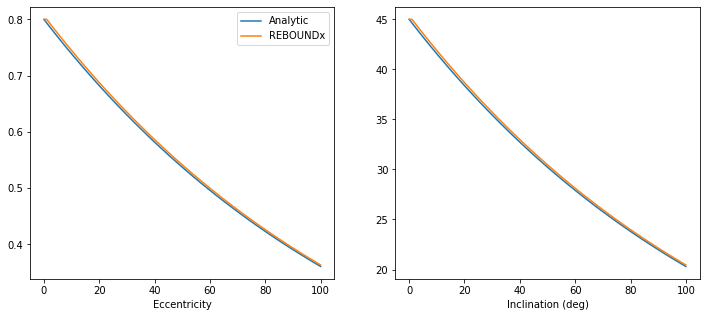

In [14]:
# Compare REBOUNDx with expected results
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(times, e_t(e0, times), label = 'Analytic')
ax[0].plot(times, eccs, label = 'REBOUNDx')
ax[0].legend()
ax[0].set_xlabel('Time (REBOUND Years)')
ax[0].set_xlabel('Eccentricity')

ax[1].plot(times, np.degrees(i_t(i0, times)))
ax[1].plot(times, np.degrees(incs))
ax[1].set_xlabel('Time (REBOUND Years)')
ax[1].set_xlabel('Inclination (deg)')